In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go 
import warnings
warnings.filterwarnings("ignore")

## download multiscorer file and install in the file directory and use conda install -c conda-forge xgboost to install xgboost for mac, close all files and reopen notebook ##

In [4]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from multiscorer import MultiScorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time


In [75]:
df = pd.read_csv('Foresteelauder.csv')

In [76]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01/12/2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01/12/2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01/12/2009 07:45,1.25,13085.0,United Kingdom


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1048575 non-null  object 
 1   StockCode    1048575 non-null  object 
 2   Description  1044203 non-null  object 
 3   Quantity     1048575 non-null  int64  
 4   InvoiceDate  1048575 non-null  object 
 5   Price        1048575 non-null  float64
 6   CustomerID   811893 non-null   float64
 7   Country      1048575 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 64.0+ MB


#now lets check how many null values we have for each column

In [37]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4372
Quantity            0
InvoiceDate         0
Price               0
CustomerID     236682
Country             0
dtype: int64

In [39]:
np.round(df.isnull().sum()["CustomerID"]/df.InvoiceDate.shape[0] * 100, 2)

22.57

comparing the invoice values, we have 22.77% of missing customer IDs, at this stage there will be the need to ask the team leader if the null values can be dropped or filled. In this case, we will drop it and create an object with the drop na df

In [40]:
df_data = df.dropna()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811893 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      811893 non-null  object 
 1   StockCode    811893 non-null  object 
 2   Description  811893 non-null  object 
 3   Quantity     811893 non-null  int64  
 4   InvoiceDate  811893 non-null  object 
 5   Price        811893 non-null  float64
 6   CustomerID   811893 non-null  float64
 7   Country      811893 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 55.7+ MB


now lets convert our dataframe InvoiceDate column to a pandas datetime object

In [41]:
df_data.InvoiceDate = pd.to_datetime(df_data.InvoiceDate)
df_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-01-12 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-01-12 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-01-12 07:45:00,1.25,13085.0,United Kingdom


In [14]:
pd.DataFrame(df_data.InvoiceDate.describe())

,InvoiceDate
count,824364
unique,41439
top,2011-11-14 15:27:00
freq,543
first,2009-12-01 07:45:00
last,2011-12-09 12:50:00


In [42]:
pd.DataFrame(df_data.StockCode.describe())

,StockCode
count,811893
unique,4645
top,85123A
freq,5280


In [43]:
pd.DataFrame(df_data.Country.describe())

,Country
count,811893
unique,41
top,United Kingdom
freq,730115


In [45]:
df_data['CustomerID'].value_counts()

17841.0    12780
14911.0    11328
12748.0     7100
14606.0     6608
15311.0     4664
           ...  
12896.0        1
15668.0        1
16605.0        1
15657.0        1
14580.0        1
Name: CustomerID, Length: 5924, dtype: int64

## EDA

QUESTION 1

How many customers are in the dataset and where are they from?

The last two codes output shows that there are 41 unique countries and 5942 Customer IDs. Alternatively print('From the dataset, the online retail shop has {} customers \
from {} different countries.'.format(len(df_data.CustomerID.unique()), len(df_data.Country.unique())))

QUESTION 2

which countries are the most represented, and what is the percentage of customers in each country?

In [65]:
ctm_cntry_df = df_data.groupby(['CustomerID', 'Country']).count().reset_index()

ctm_cntry_df = ctm_cntry_df.groupby('Country')['CustomerID'].count().reset_index().sort_values(
    by=['CustomerID'], ascending=False)

ctm_cntry_df['Percentage']= np.round(ctm_cntry_df.CustomerID / ctm_cntry_df.CustomerID.sum() * 100, 2)

ctm_cntry_df.head(10)


,Country,CustomerID,Percentage
38,United Kingdom,5397,90.90
14,Germany,106,1.79
13,France,94,1.58
32,Spain,40,0.67
3,Belgium,29,0.49
28,Portugal,24,0.40
24,Netherlands,23,0.39
34,Switzerland,22,0.37
33,Sweden,19,0.32
18,Italy,17,0.29


The output above shows the 10 top countries that purchased from the online retail shop with UK being the country with the highest number of customers.

In [66]:
percent_margin = 0.25
ctm_cntry_df['CountryCategory'] = ctm_cntry_df.Country
ctm_cntry_df.loc[ctm_cntry_df.Percentage <= percent_margin, 'CountryCategory'] = 'Other Countries'

ctm_cntry_df.head(10)


,Country,CustomerID,Percentage,CountryCategory
38,United Kingdom,5397,90.90,United Kingdom
14,Germany,106,1.79,Germany
13,France,94,1.58,France
32,Spain,40,0.67,Spain
3,Belgium,29,0.49,Belgium
28,Portugal,24,0.40,Portugal
24,Netherlands,23,0.39,Netherlands
34,Switzerland,22,0.37,Switzerland
33,Sweden,19,0.32,Sweden
18,Italy,17,0.29,Italy


In [64]:
pie_fig = px.pie(ctm_cntry_df.head(10), 
                 names='CountryCategory', 
                 values="Percentage", 
                 title="Customer Country Count in Percentage", 
                 template= "plotly_white"
                )

pie_fig.update_layout(title_x=0, 
                      legend_title="Countries Represented", 
                      legend=dict(orientation="h")
                     )

pie_fig.show(config={'displaylogo': False})



QUESTION3

What is the revenue monthly made and what is the its percantage per country?

We will combine year and month by making an integer encoding with lambda function

In [72]:
df_data['InvoiceYearMonth'] = df_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,InvoiceYearMonth,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-01-12 07:45:00,6.95,13085.0,United Kingdom,200901,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,200901,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,200901,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-01-12 07:45:00,2.10,13085.0,United Kingdom,200901,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-01-12 07:45:00,1.25,13085.0,United Kingdom,200901,30.0


In [73]:
df_data['Revenue'] = df_data.Price * df_data.Quantity
df_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,InvoiceYearMonth,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-01-12 07:45:00,6.95,13085.0,United Kingdom,200901,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,200901,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,200901,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-01-12 07:45:00,2.10,13085.0,United Kingdom,200901,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-01-12 07:45:00,1.25,13085.0,United Kingdom,200901,30.0


In [70]:
ctm_revenue = df_data.groupby('InvoiceYearMonth').Revenue.sum().reset_index()
ctm_revenue.head()


,InvoiceYearMonth,Revenue
0,200901,42708.22
1,200902,52578.19
2,200903,61534.22
3,200904,33686.86
4,200905,9803.05


In [71]:
pd.DataFrame(ctm_revenue.Revenue.describe())

,Revenue
count,3.600000e+01
mean,4.556694e+05
std,3.227232e+05
min,9.803050e+03
25%,5.011070e+04
50%,5.560725e+05
75%,6.397759e+05
max,1.004792e+06


In [79]:
line_fig = px.line(ctm_revenue, 
                   x = "InvoiceYearMonth", 
                   y = "Revenue", 
                   title = "Montly Revenue from Dec. 2009 to Dec. 2011", 
                   template= "plotly_white" 
                  )

line_fig.update_layout(title_x=0.5, 
                       showlegend=False, 
                       xaxis={"type": "category"}, 
                       xaxis_title="Invoice Year-Month", 
                       yaxis_title="Monthly Revenue"
                      )

line_fig.show(config={'displaylogo': False})


from the illustration above we can say that the highest sales took place in November 2011 followed by November 2010 and the lowest sales were recorded around November 2009

Since we analysed earlier the costumer percentage in each country, lets now visualise the revenue per country

In [80]:
cntry_revenue_df = df_data.groupby(['Country']).Revenue.sum().reset_index().sort_values(by=['Revenue'], 
                                                                                        ascending=False)

cntry_revenue_df['Percentage'] = np.round(cntry_revenue_df.Revenue / cntry_revenue_df.Revenue.sum() * 100, 2)

cntry_revenue_df.head(10)


,Country,Revenue,Percentage
38,United Kingdom,1.360000e+07,82.91
10,EIRE,5.721997e+05,3.49
24,Netherlands,5.367969e+05,3.27
14,Germany,4.109176e+05,2.50
13,France,3.217396e+05,1.96
0,Australia,1.671291e+05,1.02
34,Switzerland,9.908281e+04,0.60
32,Spain,9.158805e+04,0.56
33,Sweden,8.745542e+04,0.53
9,Denmark,6.557219e+04,0.40


In [81]:
percent_margin = 0.25

cntry_revenue_df['CountryCategory'] = cntry_revenue_df.Country
cntry_revenue_df.loc[cntry_revenue_df.Percentage <= percent_margin, 'CountryCategory'] = 'Other Countries'

cntry_revenue_df.head(10)

,Country,Revenue,Percentage,CountryCategory
38,United Kingdom,1.360000e+07,82.91,United Kingdom
10,EIRE,5.721997e+05,3.49,EIRE
24,Netherlands,5.367969e+05,3.27,Netherlands
14,Germany,4.109176e+05,2.50,Germany
13,France,3.217396e+05,1.96,France
0,Australia,1.671291e+05,1.02,Australia
34,Switzerland,9.908281e+04,0.60,Switzerland
32,Spain,9.158805e+04,0.56,Spain
33,Sweden,8.745542e+04,0.53,Sweden
9,Denmark,6.557219e+04,0.40,Denmark


In [83]:
pie_fig = px.pie(cntry_revenue_df.head(10), 
                 names="CountryCategory", 
                 values="Percentage", 
                 title="Country Revenue in Percentage", 
                 template= "plotly_white"
                )

pie_fig.update_layout(title_x=0, 
                      legend_title="Countries Represented", 
                      legend=dict(orientation="h")
                     )

pie_fig.show(config={'displaylogo': False})

# CUSTOMER PURCHASE PREDICTION

We are going to estimated if a customer will buy again in the next quarter. But first we going to study their behavioural purchase from 01-12-2009 to 30-08-2011 by using the ctm_dt to a new object ctm_bhvr_dt and then we are going to study their behavioural in the next quarter from 01-09-2011 to 30-11-2011 by creating a new object called ctm_next_quarter.

In [84]:
df_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,InvoiceYearMonth,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-01-12 07:45:00,6.95,13085.0,United Kingdom,200901,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,200901,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,200901,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-01-12 07:45:00,2.10,13085.0,United Kingdom,200901,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-01-12 07:45:00,1.25,13085.0,United Kingdom,200901,30.0


In [85]:
ctm_bhvr_dt = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,9,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2009,12,1))].reset_index(drop=True)


ctm_next_quarter = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,12,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2011,9,1))].reset_index(drop=True)


In [98]:
# get unique customers in the dataframe ctm_bhvr_dt within the date established 
ctm_dt = pd.DataFrame(ctm_bhvr_dt['CustomerID'].unique())

# Rename the column to CustomerID
ctm_dt.columns = ['CustomerID']
ctm_dt.head()

,CustomerID
0,17243.0
1,12664.0
2,14685.0
3,13768.0
4,16335.0


now we will find the first purchase made by each customer in the next quarter. We will create a df with CustomerID and customers first and last purchase.

In [89]:
ctm_1st_purchase_in_next_quarter = ctm_next_quarter.groupby('CustomerID').InvoiceDate.min().reset_index()
ctm_1st_purchase_in_next_quarter.columns = ['CustomerID','MinPurchaseDate']
ctm_1st_purchase_in_next_quarter.head()

,CustomerID,MinPurchaseDate
0,12347.0,2011-09-06 13:01:00
1,12348.0,2011-09-25 13:13:00
2,12349.0,2011-11-21 09:51:00
3,12352.0,2011-09-20 14:34:00
4,12355.0,2011-09-05 13:49:00


In [90]:
ctm_last_purchase_bhvr_dt = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_last_purchase_bhvr_dt.columns = ['CustomerID','MaxPurchaseDate']
ctm_last_purchase_bhvr_dt.head()


,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-07-04 10:43:00
2,12348.0,2011-05-04 10:47:00
3,12349.0,2010-10-28 08:23:00
4,12350.0,2011-02-02 16:01:00


now, lets merge both Df

In [91]:
ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='CustomerID', 
                              how='left')
ctm_purchase_dates.head()


,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12346.0,2011-01-18 10:17:00,NaT
1,12347.0,2011-07-04 10:43:00,2011-09-06 13:01:00
2,12348.0,2011-05-04 10:47:00,2011-09-25 13:13:00
3,12349.0,2010-10-28 08:23:00,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00,NaT


now, lets calculate the difference in days  between first and last purchase.

In [92]:
ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days

ctm_purchase_dates.head()


,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12346.0,2011-01-18 10:17:00,NaT,NaN
1,12347.0,2011-07-04 10:43:00,2011-09-06 13:01:00,64.0
2,12348.0,2011-05-04 10:47:00,2011-09-25 13:13:00,144.0
3,12349.0,2010-10-28 08:23:00,2011-11-21 09:51:00,389.0
4,12350.0,2011-02-02 16:01:00,NaT,NaN


lets merge NextPurchaseDay with ctm_dt

In [99]:
ctm_dt = pd.merge(ctm_dt, ctm_purchase_dates[['CustomerID','NextPurchaseDay']], on='CustomerID', how='left')
ctm_dt.head()



,CustomerID,NextPurchaseDay
0,17243.0,13.0
1,12664.0,56.0
2,14685.0,NaN
3,13768.0,NaN
4,16335.0,NaN


In [100]:
ctm_dt.isnull().sum()

CustomerID            0
NextPurchaseDay    3097
dtype: int64

In [101]:
ctm_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5418 entries, 0 to 5417
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       5418 non-null   float64
 1   NextPurchaseDay  2321 non-null   float64
dtypes: float64(2)
memory usage: 127.0 KB


the nextpurchase day has more than half of missing values. for that matter we cannot ignore. Therefore we aregoing to fill na with 9999 however we need to study better this techniques.

In [102]:
ctm_dt = ctm_dt.fillna(9999)
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,17243.0,13.0
1,12664.0,56.0
2,14685.0,9999.0
3,13768.0,9999.0
4,16335.0,9999.0




Next, we will define some features and add them to the dataframe ctm_dt to build our machine learning model. We will use the Recency - Frequency - Monetary Value segmentation method. That is, we will put the customers into groups based on the following:

    - Recency: Customers purchase behaviour based on their most recent purchase date and how many days they have been inactive since their last purchase.

    - Frequency: Customers purchase behaviour based on the number of times they buy from the online retail shop.

    - Monetary Value/Revenue: Customers purchase behaviour based the revenue they generate.

After we will apply K-means clustering to assign customers a score to each of the features.


## Recency

Let's find the most recent purchase date of each customer and see how many days they have been inactive. Afterwards, we can apply K-means clustering to assign customers a recency score.

In [103]:
ctm_max_purchase = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
ctm_max_purchase.head()


,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-07-04 10:43:00
2,12348.0,2011-05-04 10:47:00
3,12349.0,2010-10-28 08:23:00
4,12350.0,2011-02-02 16:01:00


In [104]:
# Find the recency in days 
ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days

# Merge the dataframes ctm_dt and ctm_max_purchase[['CustomerID', 'Recency']] on the CustomerID column.
ctm_dt = pd.merge(ctm_dt, ctm_max_purchase[['CustomerID', 'Recency']], on='CustomerID')
ctm_dt.head()


,CustomerID,NextPurchaseDay,Recency
0,17243.0,13.0,13
1,12664.0,56.0,43
2,14685.0,9999.0,269
3,13768.0,9999.0,426
4,16335.0,9999.0,451


In [105]:
pd.DataFrame(ctm_dt.Recency.describe())

,Recency
count,5418.000000
mean,195.450166
std,166.536657
min,0.000000
25%,49.000000
50%,150.500000
75%,311.000000
max,626.000000


mean is 195 days and median 150

In [107]:
# plot histogram
hist_fig = px.histogram(ctm_dt, 
                        x="Recency", 
                        title="Customers Recency in Days", 
                        template= "plotly_white" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Recency in groups of 20 days", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show(config={'displaylogo': False})


Next we will apply K-means clustering to assign a recency score. However, we need to know how many clusters in order to use the K-means algorithm. We will apply Elbow Method to determine how many clusters we will need. The Elbow Method simply tells the optimal cluster number for optimal inertia.

In [108]:
my_dict={}
ctm_recency = ctm_dt[['Recency']]
for idx in range(1, 10):
    kmeans = KMeans(n_clusters=idx, max_iter=1000).fit(ctm_recency)
    ctm_recency["clusters"] = kmeans.labels_
    my_dict[idx] = kmeans.inertia_ 

line_fig = px.line(x=list(my_dict.keys()), 
                   y=list(my_dict.values()), 
                   template="plotly_dark"
                  )

line_fig.update_layout(title_x=0, 
                       xaxis_title="Number of cluster", 
                       yaxis_title=""
                      )

line_fig.show(config={'displaylogo': False})


In [109]:
number_of_clusters = 4

now lets build a 4 clusters for recency and add it to dataframe

In [110]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Recency']])
ctm_dt['RecencyCluster'] = kmeans.predict(ctm_dt[['Recency']])
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,17243.0,13.0,13,1
1,12664.0,56.0,43,1
2,14685.0,9999.0,269,0
3,13768.0,9999.0,426,3
4,16335.0,9999.0,451,3


In [111]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final

In [112]:
ctm_dt = order_cluster(ctm_dt, 'Recency', 'RecencyCluster', False)
ctm_dt.head()


,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,17243.0,13.0,13,3
1,12664.0,56.0,43,3
2,18077.0,51.0,3,3
3,16719.0,74.0,48,3
4,13317.0,88.0,81,3


In [113]:
#print cluster characteristics
ctm_dt.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,717.0,504.288703,60.58130,411.0,451.0,498.0,553.0,626.0
1,1327.0,314.795026,40.91016,251.0,280.0,310.0,343.0,409.0
2,1036.0,171.085907,37.93943,108.0,141.0,167.0,201.0,241.0
3,2338.0,43.796407,30.85811,0.0,15.0,40.0,69.0,107.0


we filled the 0 recency with 3 cluster values

## Frequency

Next, we will find customers purchase behaviour based on the number of times they buy from the online retail shop. That is, the total number of orders by each customer.

In [114]:
#get order counts for each user and create a dataframe with it
ctm_frequency = df_data.groupby('CustomerID').InvoiceDate.count().reset_index()
ctm_frequency.columns = ['CustomerID','Frequency']


In [115]:
ctm_dt = pd.merge(ctm_dt, ctm_frequency, on='CustomerID')

ctm_dt.head()


,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,17243.0,13.0,13,3,1146
1,12664.0,56.0,43,3,46
2,18077.0,51.0,3,3,377
3,16719.0,74.0,48,3,450
4,13317.0,88.0,81,3,381


In [116]:
pd.DataFrame(ctm_dt.Frequency.describe())

,Frequency
count,5418.000000
mean,146.928202
std,366.930222
min,1.000000
25%,23.000000
50%,59.000000
75%,155.000000
max,12780.000000


In [117]:
# plot histogram
hist_fig = px.histogram(x=ctm_dt.query('Frequency < 1200')['Frequency'], 
                        title="Customers with Purchase Frequency less than 1200", 
                        template= "plotly_dark" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Customer Frequency Purchase in groups of 20", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show(config={'displaylogo': False})


In [118]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Frequency']])
ctm_dt['FrequencyCluster'] = kmeans.predict(ctm_dt[['Frequency']])

In [119]:
ctm_dt = order_cluster(ctm_dt, 'Frequency', 'FrequencyCluster', False)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17243.0,13.0,13,3,1146,2
1,16719.0,74.0,48,3,450,2
2,17085.0,9999.0,23,3,1005,2
3,16710.0,54.0,28,3,987,2
4,17287.0,68.0,43,3,497,2


In [120]:
#see details of each cluster
ctm_dt.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2.0,12054.000000,1026.719046,11328.0,11691.00,12054.0,12417.0,12780.0
1,14.0,3843.428571,1466.704926,2428.0,2814.25,3310.0,4481.0,7100.0
2,419.0,696.047733,313.325644,392.0,469.00,580.0,832.5,2061.0
3,4983.0,85.590407,88.853409,1.0,21.00,51.0,121.0,390.0


higher frequency meana better customer

## Revenue

In [121]:
ctm_revenue = df_data.groupby('CustomerID').Revenue.sum().reset_index()

In [122]:
#merge it with our ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_revenue, on='CustomerID')
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17243.0,13.0,13,3,1146,2,20104.91
1,16719.0,74.0,48,3,450,2,3828.55
2,17085.0,9999.0,23,3,1005,2,7757.41
3,16710.0,54.0,28,3,987,2,6336.34
4,17287.0,68.0,43,3,497,2,4095.71


In [123]:
# plot histogram
hist_fig = px.histogram(x=ctm_dt.query('Revenue < 10000')['Revenue'], 
                        title="Customers with Monetary Value below 10000", 
                        template= "plotly_white" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Customers Revenue", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show(config={'displaylogo': False})


In [124]:
#apply clustering
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Revenue']])
ctm_dt['RevenueCluster'] = kmeans.predict(ctm_dt[['Revenue']])


In [125]:
#order the cluster numbers
ctm_dt = order_cluster(ctm_dt, 'Revenue', 'RevenueCluster', True)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17243.0,13.0,13,3,1146,2,20104.91,0
1,16719.0,74.0,48,3,450,2,3828.55,0
2,17085.0,9999.0,23,3,1005,2,7757.41,0
3,16710.0,54.0,28,3,987,2,6336.34,0
4,17287.0,68.0,43,3,497,2,4095.71,0


In [126]:
#show details of the dataframe
ctm_dt.groupby('RevenueCluster')['Revenue'].describe()


,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,5360.0,2068.503729,3285.034844,-25111.09,353.2275,922.245,2304.6800,26300.37
1,48.0,50638.694854,22391.404013,26626.80,33578.7575,44915.100,59035.6350,112698.61
2,8.0,194769.605000,62783.320464,132495.62,141477.0350,176100.510,241171.1825,296564.69
3,2.0,549171.865000,53114.771346,511614.05,530392.9575,549171.865,567950.7725,586729.68


## Overall Score

Lets sum all the cluster features

In [127]:
#calculate overall score and use mean() to see details
ctm_dt['OverallScore'] = ctm_dt['RecencyCluster'] + ctm_dt['FrequencyCluster'] + ctm_dt['RevenueCluster']
ctm_dt.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
2,533.000000,395.000000,3243.930000
3,498.689373,46.989101,543.070138
4,309.677991,93.110783,1144.206686
5,136.299775,264.782870,3866.529041
6,46.192113,135.691102,3217.283403
7,13.526316,696.421053,111913.591579
8,34.000000,1045.000000,586729.680000


score 8 customers are the best customers with the highest recency, frequency and revenue

In [133]:
ctm_dt['Segment'] = 'Low-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 4, 'Segment'] = 'Mid-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 6, 'Segment'] = 'High-Value'
ctm_dt.head(5)

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17243.0,13.0,13,3,1146,2,20104.91,0,5,Mid-Value
1,16719.0,74.0,48,3,450,2,3828.55,0,5,Mid-Value
2,17085.0,9999.0,23,3,1005,2,7757.41,0,5,Mid-Value
3,16710.0,54.0,28,3,987,2,6336.34,0,5,Mid-Value
4,17287.0,68.0,43,3,497,2,4095.71,0,5,Mid-Value


In [138]:
#A scatter plot of Revenue verses Frequency

ctm_graph = ctm_dt.query("Revenue < 50000 and Frequency < 2000")


plot_data = [
    go.Scatter(
        x=ctm_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=ctm_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low-Value',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='purple',
            opacity=0.8
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=ctm_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid-Value',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'High-Value'")['Frequency'],
        y=ctm_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High-Value',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='blue',
            opacity=0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments', 
        title_x = 0.5, 
        template="plotly_white"
    )

fig = go.Figure(
        data=plot_data, 
        layout=plot_layout
    )

#pyoff.iplot(fig)
fig.show(config={'displaylogo': False})


In [140]:
# Scatter Plot of Revenue verses Recency

ctm_graph = ctm_dt.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=ctm_graph.query("Segment == 'Low-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low-Value',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid-Value',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'High-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High-Value',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments', 
        title_x = 0.5, 
        template="plotly_white"
    )

fig = go.Figure(
        data=plot_data, 
        layout=plot_layout
    )

#pyoff.iplot(fig)
fig.show(config={'displaylogo': False})

In [141]:
# Scatter Plot of Revenue verses Frequency

ctm_graph = ctm_dt.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=ctm_graph.query("Segment == 'Low-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low-Value',
        marker= dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
           )
    ),
    
    go.Scatter(
        x=ctm_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid-Value',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
           )
    ),
    
    go.Scatter(
        x=ctm_graph.query("Segment == 'High-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High-Value',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments', 
        title_x = 0.5,
        template="plotly_white"
    )

fig = go.Figure(
        data=plot_data, 
        layout=plot_layout
    )

#pyoff.iplot(fig)
fig.show(config={'displaylogo': False})

Let us create a copy of the dataframe ctm_dt and apply the method get_dummies to it so as to convert all categorical column Segment (low, mid and high value) to indicator variables.

In [142]:
#create ctm_class as a copy of ctm_dt before applying get_dummies
ctm_class = ctm_dt.copy()
ctm_class = pd.get_dummies(ctm_class)
ctm_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,17243.0,13.0,13,3,1146,2,20104.91,0,5,0,0,1
1,16719.0,74.0,48,3,450,2,3828.55,0,5,0,0,1
2,17085.0,9999.0,23,3,1005,2,7757.41,0,5,0,0,1
3,16710.0,54.0,28,3,987,2,6336.34,0,5,0,0,1
4,17287.0,68.0,43,3,497,2,4095.71,0,5,0,0,1




Since our goal is to estimate whether a customer will make a purchase in the next quarter, we will create a new column NextPurchaseDayRange with values as either $1$ or $0$ defined as follows:

    - If the value is 1, then it indicates that the customer will buy something in the next quarter, i.e., 90 days from his or her last purchase.
    - If 0 indicates that the customer will buy something in more than 90 days from his or her last purchase.

In [143]:
ctm_class['NextPurchaseDayRange'] = 1  ## less than 3 months
ctm_class.loc[ctm_class.NextPurchaseDay>90,'NextPurchaseDayRange'] = 0 # more than 3 months
ctm_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
0,17243.0,13.0,13,3,1146,2,20104.91,0,5,0,0,1,1
1,16719.0,74.0,48,3,450,2,3828.55,0,5,0,0,1,1
2,17085.0,9999.0,23,3,1005,2,7757.41,0,5,0,0,1,0
3,16710.0,54.0,28,3,987,2,6336.34,0,5,0,0,1,1
4,17287.0,68.0,43,3,497,2,4095.71,0,5,0,0,1,1


In [144]:
ctm_class['NextPurchaseDayRange'].value_counts()

0    4446
1     972
Name: NextPurchaseDayRange, dtype: int64

Finally in this section, let's see the correlation between our features and label. We can achieve this by applying the corr method to the dataframe ctm_dt.

In [145]:
corr_matrix = ctm_class[ctm_class.columns].corr()
corr_df = pd.DataFrame(corr_matrix.min())
corr_df.columns = ['MinCorrelationCoeff']
corr_df['MaxCorrelationCoeff'] = corr_matrix[corr_matrix < 1].max()
corr_df

,MinCorrelationCoeff,MaxCorrelationCoeff
CustomerID,-0.043662,0.041524
NextPurchaseDay,-0.549969,0.427161
Recency,-0.967224,0.859830
RecencyCluster,-0.967224,0.967870
Frequency,-0.702998,0.476733
FrequencyCluster,-0.702998,0.260066
Revenue,-0.374413,0.829262
RevenueCluster,-0.333692,0.829262
OverallScore,-0.932944,0.967870
Segment_High-Value,-0.076948,0.676165


From the output above, we observe that Overall Score has the highest positive correlation of $0.97$ with RecencyCluster and Segment_Low-Value has the highest negative of -0.99 with Segment_Mid-Value.

We can get a good visualisation of the coefficient matrix below.

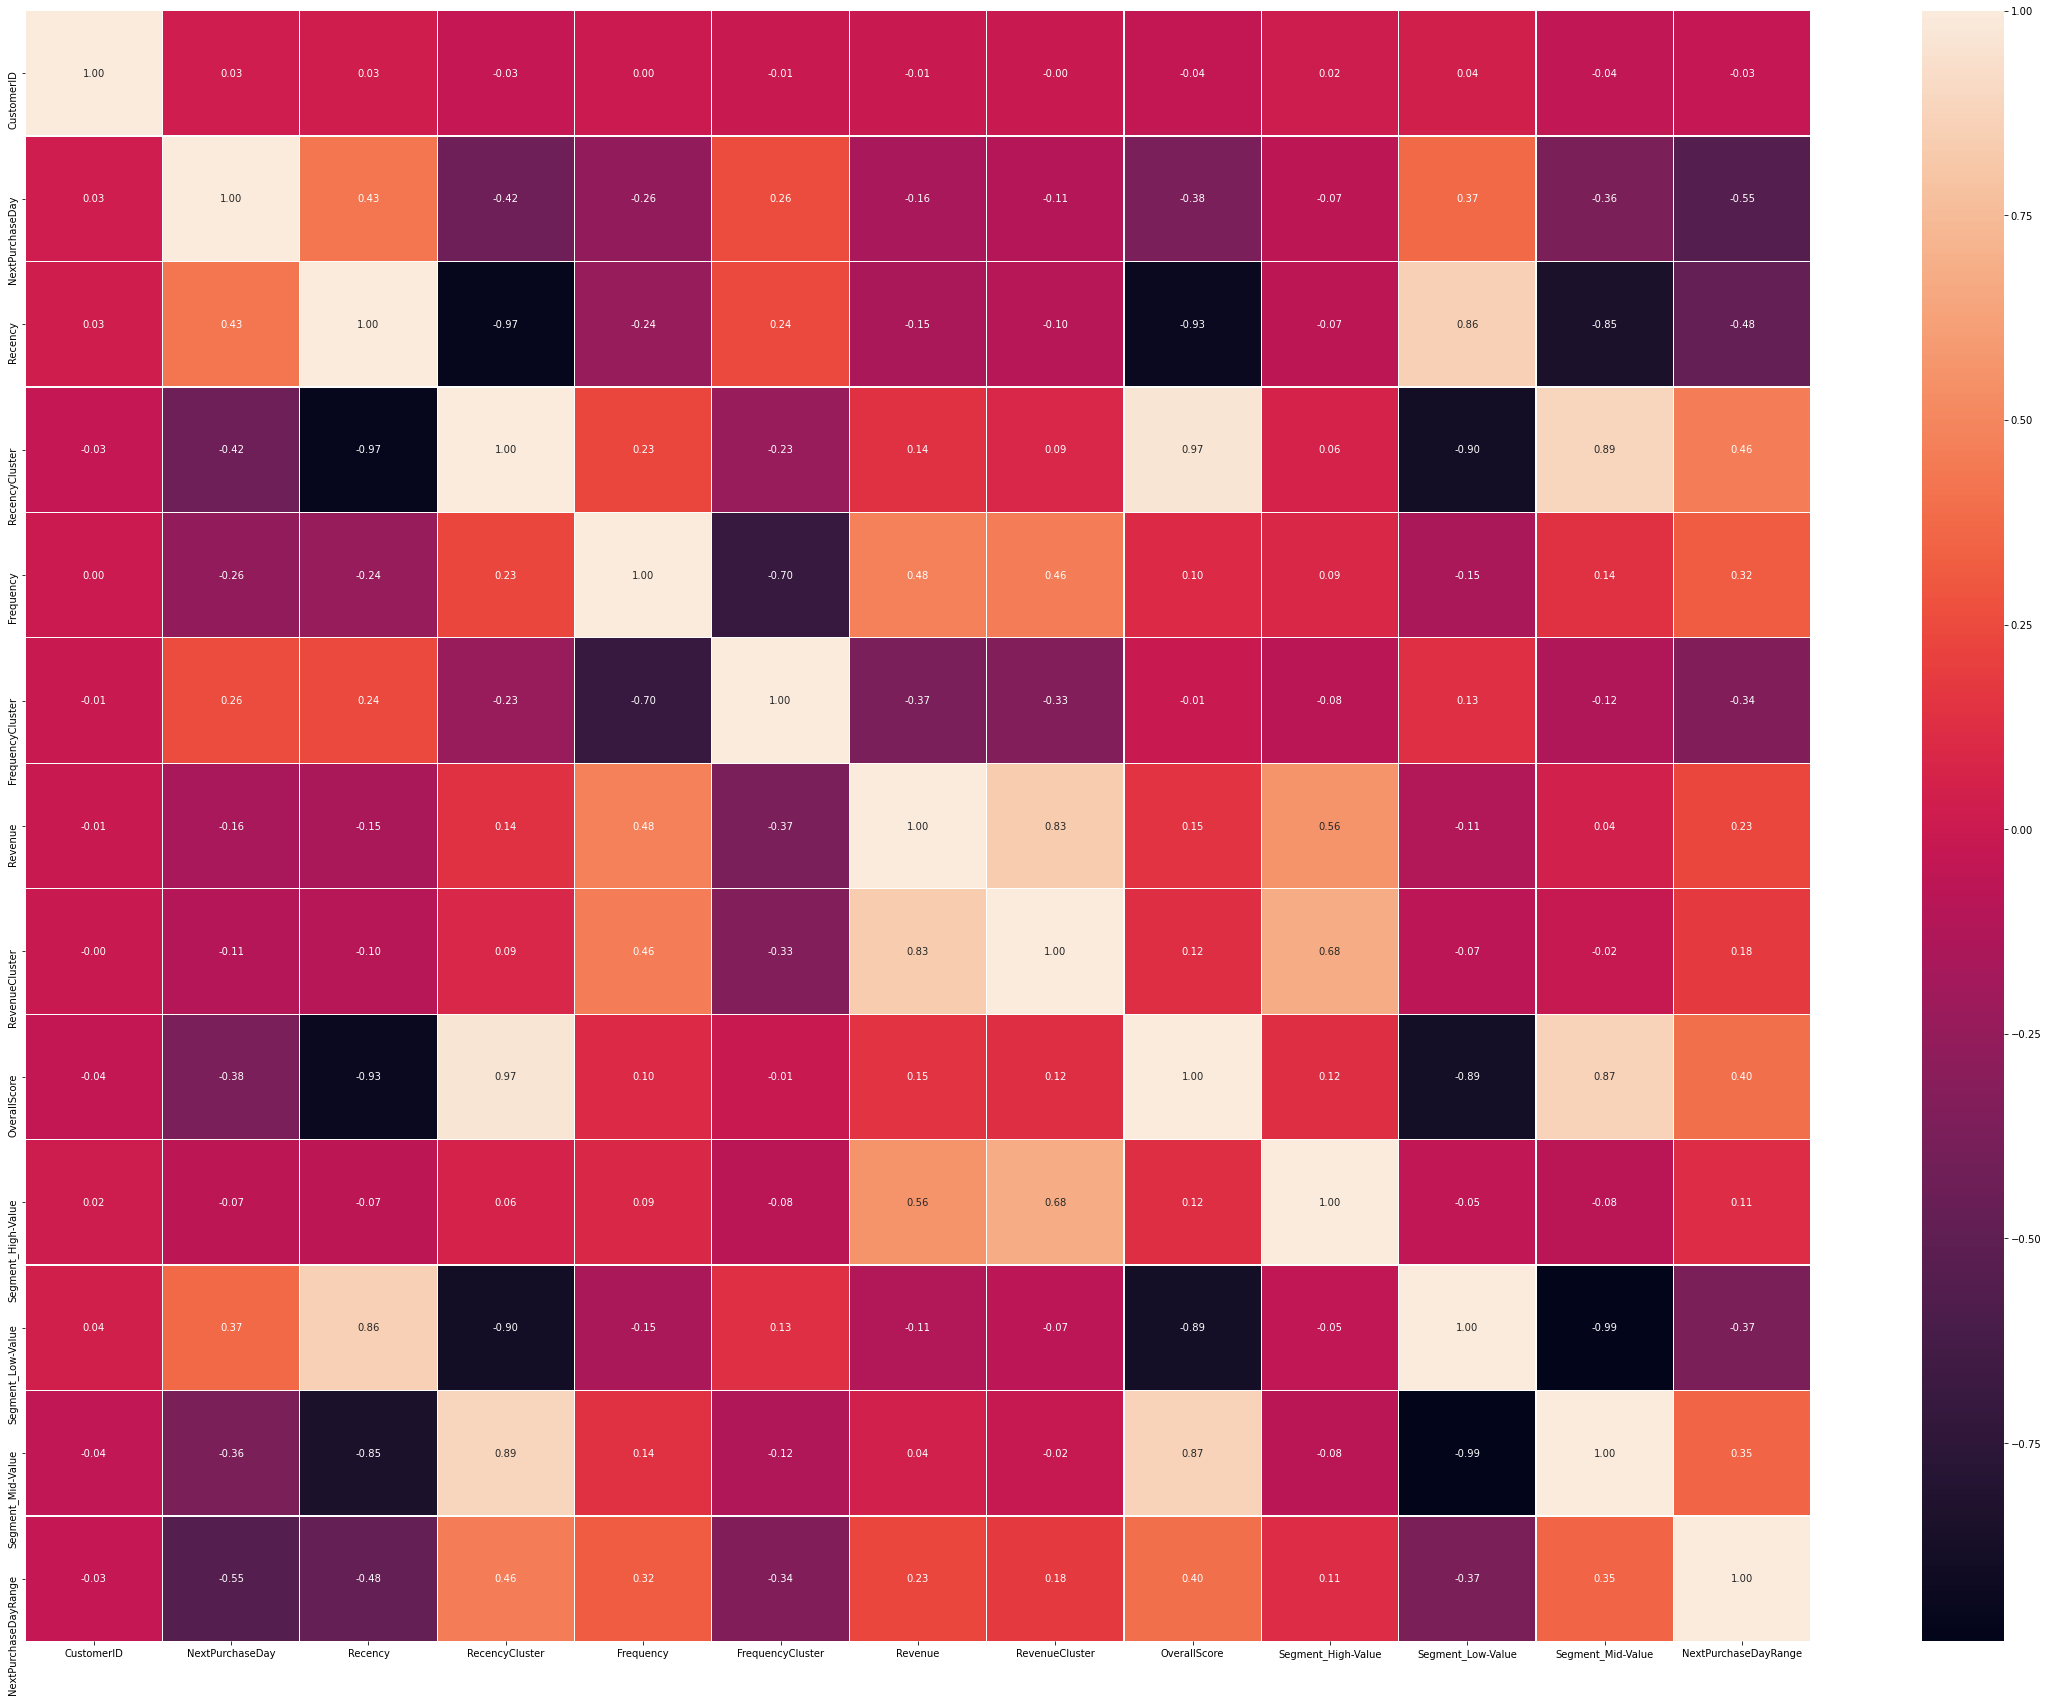

In [146]:
plt.figure(figsize = (40, 30))
sns.heatmap(corr_matrix, annot = True, linewidths=0.2, fmt=".2f");

## Building ML Models

In [147]:

ctm_class = ctm_class.drop('NextPurchaseDay', axis=1)

In [148]:
X, y = ctm_class.drop('NextPurchaseDayRange', axis=1), ctm_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [149]:
X_train

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
499,15602.0,100,3,141,3,2975.97,0,6,0,0,1
3374,18066.0,286,1,53,3,1440.40,0,4,0,1,0
5167,17893.0,125,2,16,3,112.25,0,5,0,0,1
2262,17295.0,82,3,69,3,556.95,0,6,0,0,1
847,12909.0,96,3,168,3,3034.77,0,6,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4081,15868.0,483,0,4,3,94.53,0,3,0,1,0
269,13069.0,26,3,1144,2,8467.23,0,5,0,0,1
3642,15780.0,257,1,29,3,475.28,0,4,0,1,0
4691,15405.0,178,2,30,3,659.84,0,5,0,0,1


In [150]:
X_test

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
161,16923.0,26,3,1158,2,12793.38,0,5,0,0,1
3757,18199.0,575,0,21,3,342.20,0,3,0,1,0
1543,13748.0,58,3,59,3,2268.35,0,6,0,0,1
867,17373.0,34,3,91,3,1167.50,0,6,0,0,1
800,14970.0,37,3,127,3,3593.40,0,6,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1513,15834.0,58,3,383,3,3600.29,0,6,0,0,1
1022,12910.0,34,3,138,3,5747.02,0,6,0,0,1
4381,13635.0,174,2,167,3,2948.22,0,5,0,0,1
1863,17058.0,99,3,62,3,1179.89,0,6,0,0,1


In [151]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

In [153]:
# Measuring the metrics of the different models

scorer = MultiScorer({'accuracy'  : (accuracy_score , {}), 
                      'f1_score'  : (f1_score       , {'pos_label': 3, 'average':'macro'}), 
                      'recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}), 
                      'precision' : (precision_score, {'pos_label': 3, 'average':'macro'})
                     })

# A dictionary for all the distinct models and their respective metrics
model_scores_dict = {'model_name' : [], 
                     'accuracy'   : [], 
                     'f1_score'   : [], 
                     'recall'     : [], 
                     'precision'  : [],
                     'time'       : []
                    }

# For each model name and model in models
for model_name, model in models: 
    
    # Add model_name to model_scores_dict 
    model_scores_dict['model_name'].append(model_name)
    #print(model_name)
    kfold = KFold(n_splits=2, random_state=24, shuffle=True)
    start = time.time()
    _ = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scorer)
    cv_result = scorer.get_results()
    
    # For each metric in cv_result.keys()
    for metric_name in cv_result.keys():
        # Get the average of cv_result[metric_name]
        average_score = np.average(cv_result[metric_name])
        # Update model_scores_dict with average_score for model_name
        model_scores_dict[metric_name].append(average_score)
        #print('%s : %f' %(metric_name, average_score))

    model_scores_dict['time'].append((time.time() - start))
    #print('time : ', time.time() - start, '\n\n')
        
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["accuracy", "f1_score", "time"], ascending=False)

,accuracy,f1_score,recall,precision,time
model_name,,,,,
LogisticRegression,0.892017,0.811636,0.803495,0.822121,0.100666
RandomForestClassifier,0.879480,0.806250,0.824052,0.803663,0.604023
GaussianNB,0.874135,0.805251,0.836511,0.795805,0.023324
xgb.XGBClassifier,0.872481,0.769978,0.773443,0.799877,0.630167
SVC,0.871424,0.762128,0.769078,0.804971,0.646395
DecisionTreeClassifier,0.870374,0.764471,0.770001,0.798786,0.034959
KNeighborsClassifier,0.868218,0.761382,0.762054,0.790487,0.248432


Let's see how we could improve the existing model XGB by finding suitable parameters via the process of hyperparameter tuning using GridSearchCV. We will check if the improved XGB Classifier model outperforms the LogisticRegression model.

In [154]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), 
                             param_grid = parameter, 
                             scoring='accuracy', 
                             n_jobs=-1, 
                             #iid=False, 
                             cv=2
                            )

p_grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample

In [155]:
p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.8876326718966313)

In [156]:
refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', 
                                      max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                      min_child_weight=list(p_grid_search.best_params_.values())[-1]+4
                                     ).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(refined_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(refined_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.89


lets predict with two models

In [157]:
ref_xgb_pred_y = refined_xgb_model.predict(X_test)

In [158]:
log_reg_pred_y = LogisticRegression().fit(X_train, y_train).predict(X_test)

Let compute the confusion matrices of these two models with the user-defined function get_confusion_matrix defined below.

In [159]:
def get_confusion_matrix(y_test, y_pred):
    """
    Displays the confusion matrix of the input numpy arrays y_test and y_pred.
    
    INPUT: 
        y_test - A numpy array 
        y_pred - A numpy array
        
    OUTPUT:
        NoneType
    """
    
    data = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap="Spectral")
    plt.show()

Let's get the confusion matrix for y_test and ref_xgb_pred_y, i.e., for the improved XGB classifier model and y_test and log_reg_pred_y, i.e., for the LogisticRegression model.

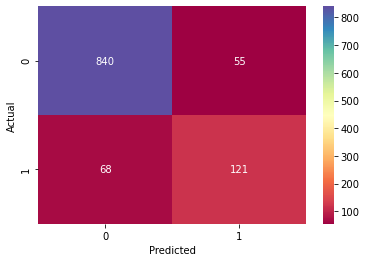

In [160]:
get_confusion_matrix(np.array(y_test), ref_xgb_pred_y)

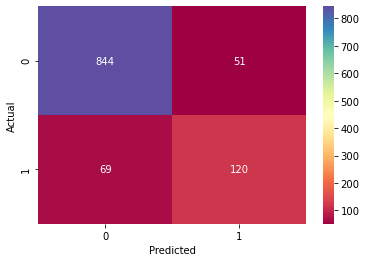

In [161]:
get_confusion_matrix(np.array(y_test), log_reg_pred_y)

Let's check if the refined XGB Classifier outperforms the LogisticRegression for the other metrics.

In [162]:
# A dictionary of model names with the various metrics
ref_xgb_log_reg_dict = {"model_name" : ["xgb.XGBClassifier", "LogisticRegression"], 
                        "accuracy"   : [accuracy_score(y_test, ref_xgb_pred_y), accuracy_score(y_test, log_reg_pred_y)], 
                        "f1_score"   : [f1_score(y_test, ref_xgb_pred_y), f1_score(y_test, log_reg_pred_y)], 
                        "recall"     : [recall_score(y_test, ref_xgb_pred_y), recall_score(y_test, log_reg_pred_y)], 
                        "precision"  : [precision_score(y_test, ref_xgb_pred_y), precision_score(y_test, log_reg_pred_y)]
                       }

# Create a dataframe with ref_xgb_log_reg_dict
ref_xgb_log_reg_df = pd.DataFrame(ref_xgb_log_reg_dict).set_index("model_name")

# Order the dataframe ref_xgb_log_reg_df by the metric values in increasing order
ref_xgb_log_reg_df.sort_values(by=["accuracy", "f1_score", "recall", "precision"], ascending=False)


,accuracy,f1_score,recall,precision
model_name,,,,
LogisticRegression,0.889299,0.666667,0.634921,0.701754
xgb.XGBClassifier,0.886531,0.663014,0.640212,0.687500


Logistic Regression still the best model.

## Conclusion

In summary I observed the following:

    From the dataset, the online retail shop has 5942 customers from 41 different countries.

    The top 3 countries are the United Kingdom, Germany and France with the United Kingdom recording the 90.85% of the customers of the online retail shop.

    The online retail shop made the highest sales in November 2010, followed by November 2011. Also, there was a rise in monthly sales after August.

    The online retail shop got most of it revenue from customers residing in the United Kingdom followed by The Republic of Ireland, The Netherlands, Germany and France.

Finally, we introduced new features into our dataframe, ctm_dt and we builded an unsupervised machine learning model that will help us decide if customer will buy something again from the online shop in the next quarter, i.e., 90 days from the date of his/her last purchase. Among the models that we used, we had to improve the XGB classifier model by the process of hyperparameter tuning to outperform the LogisticRegression model, but still Logistic Regression was the best model.